Get dataset to notebook

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"frankprojects","key":"3c59f02117489c72064f3b73bdf8d815"}'}

In [ ]:
!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!pwd
!kaggle datasets list

-rw-r--r-- 1 root root 69 Apr 14 22:48 kaggle.json
/content
ref                                                        title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
salvatorerastelli/spotify-and-youtube                      Spotify and Youtube                              9MB  2023-03-20 15:43:25           6524        250  1.0              
erdemtaha/cancer-data                                      Cancer Data                                     49KB  2023-03-22 07:57:00           2295         61  1.0              
ulrikthygepedersen/fastfood-nutrition                      Fastfood Nutrition                              12KB  2023-03-21 10:02:41           2408         49  1.0              
lokeshparab/amazon-products-dataset               

In [ ]:
!kaggle datasets download -d cookiefinder/tomato-disease-multiple-sources

100% 1.37G/1.37G [00:49<00:00, 26.1MB/s]
100% 1.37G/1.37G [00:50<00:00, 29.4MB/s]


In [ ]:
!unzip /content/tomato-disease-multiple-sources.zip

Streaming output truncated to the last 5000 lines.
  inflating: valid/Late_blight/9afc2537-1b13-4c25-b5ed-5b8de511b0ab___GHLB2 Leaf 9033.JPG  
  inflating: valid/Late_blight/9bb49d22-976d-40c3-bc9a-bff5cbbd8e28___RS_Late.B 5057.JPG  
  inflating: valid/Late_blight/9c274db5-2f89-4f3c-b9e2-4d5ebc54ddad___GHLB2 Leaf 9096.JPG  
  inflating: valid/Late_blight/9c726f4e-045b-4080-b53d-d7e66d45bcb1___RS_Late.B 4876.JPG  
  inflating: valid/Late_blight/9e5dd34f-124c-4a64-ba9f-77c8d05faa9c___GHLB2 Leaf 8749.JPG  
  inflating: valid/Late_blight/9e633823-3dde-450c-8172-733021e4dff0___RS_Late.B 6414.JPG  
  inflating: valid/Late_blight/9ecb8001-2f48-4487-b287-535dbcfb5c2f___RS_Late.B 6206.JPG  
  inflating: valid/Late_blight/9f7dcd60-e691-4c1e-830e-7495f7cc123d___RS_Late.B 6166.JPG  
  inflating: valid/Late_blight/Bacterial_spots2276_jpg.rf.5becd3793ec2a532bf8f111d60911c63.jpg  
  inflating: valid/Late_blight/IMG_1526_jpg.rf.5e25005985e2b12a6f52bfa7120f3eee.jpg  
  inflating: valid/Late_blight/IMG_

In [ ]:
!kaggle datasets download -d kareem3egm/cucumber-plant-diseases-dataset

 99% 756M/760M [00:25<00:00, 26.8MB/s]
100% 760M/760M [00:25<00:00, 30.9MB/s]


In [ ]:
!unzip /content/cucumber-plant-diseases-dataset.zip

Archive:  /content/cucumber-plant-diseases-dataset.zip
  inflating: Cucumber plant diseases dataset/single_prediction/IMG20200629182914.jpg  
  inflating: Cucumber plant diseases dataset/single_prediction/IMG20200629182955.jpg  
  inflating: Cucumber plant diseases dataset/single_prediction/photo_2020-06-27_23-50-59.jpg  
  inflating: Cucumber plant diseases dataset/single_prediction/photo_2020-06-27_23-53-33.jpg  
  inflating: Cucumber plant diseases dataset/testing/Ill_cucumber/photo_2020-06-27_23-53-49.jpg  
  inflating: Cucumber plant diseases dataset/testing/Ill_cucumber/photo_2020-06-27_23-53-50.jpg  
  inflating: Cucumber plant diseases dataset/testing/Ill_cucumber/photo_2020-06-27_23-53-51 (2).jpg  
  inflating: Cucumber plant diseases dataset/testing/Ill_cucumber/photo_2020-06-27_23-53-51.jpg  
  inflating: Cucumber plant diseases dataset/testing/Ill_cucumber/photo_2020-06-27_23-53-52.jpg  
  inflating: Cucumber plant diseases dataset/testing/Ill_cucumber/photo_2020-06-27_23-5

Import needed modules

In [ ]:
import os
import cv2
import time
import shutil
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
sns.set_style('darkgrid')
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
  print("Found GPU at: {}".format(device_name))
else:
  device_name = "/device:CPU:0"
  print("No GPU, using {}.".format(device_name))
print ('modules loaded')

Found GPU at: /device:GPU:0
modules loaded


# Create needed functions

Function to create dataframe

In [ ]:
def define_paths(dir):
    filepaths = []
    labels = []
    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    return filepaths, labels

def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

def create_df(tr_dir, val_dir):
    # train dataframe
    files, classes = define_paths(tr_dir)
    train_df = define_df(files, classes)

    # valid and test dataframe
    files, classes = define_paths(tr_dir)
    dummy_df = define_df(files, classes)
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123, stratify= strat)
    return train_df, valid_df, test_df

Function to generate images from dataframe

In [ ]:
def create_gens(train_df, valid_df, test_df, batch_size):
    img_size = (224, 224)
    channels = 3
    img_shape = (img_size[0], img_size[1], channels)
    ts_length = len(test_df)
    test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size
    def scalar(img):
        return img
    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)
    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)
    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)
    return train_gen, valid_gen, test_gen

Function to show images

In [ ]:
def show_images(gen):
    g_dict = gen.class_indices
    classes = list(g_dict.keys())
    images, labels = next(gen)
    plt.figure(figsize= (20, 20))
    length = len(labels)
    sample = min(length, 25)
    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

Callback Class

In [ ]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, base_model, patience, stop_patience, threshold, factor, batches, initial_epoch, epochs):
        super(MyCallback, self).__init__()
        self.model = model
        self.base_model = base_model
        self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor # factor by which to reduce the learning rate
        self.batches = batches # number of training batch to runn per epoch
        self.initial_epoch = initial_epoch
        self.epochs = epochs
        # callback variables
        self.count = 0 # how many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1   # epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initial learning rate and save it
        self.highest_tracc = 0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf # set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights = self.model.get_weights()   # save initial weights if they have to get restored

    # Define a function that will run when train begins
    def on_train_begin(self, logs= None):
        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()

    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)
        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights

    def on_train_batch_end(self, batch, logs= None):
        acc = logs.get('accuracy') * 100 # get batch accuracy
        loss = logs.get('loss')
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '') # prints over on the same line to show running batch count

    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()

    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr = lr
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        loss = logs.get('loss')  # get training loss for this epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch

        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

            if acc > self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc = acc # set new highest training accuracy
                self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss
            if v_loss < self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights() # validation loss improved so save the weights
                self.count = 0 # reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch
            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                else:
                    self.count = self.count + 1 # increment the patience counter
                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training

Function to plot history of training

In [ ]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout
    plt.show()


Function to create Confusion Matrix

In [ ]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()
	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)
	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')
	else:
		print('Confusion Matrix, Without Normalization')
	print(cm)
	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

# Model Structure

Show images sample

Found 25851 validated image filenames belonging to 11 classes.
Found 15510 validated image filenames belonging to 11 classes.
Found 10341 validated image filenames belonging to 11 classes.


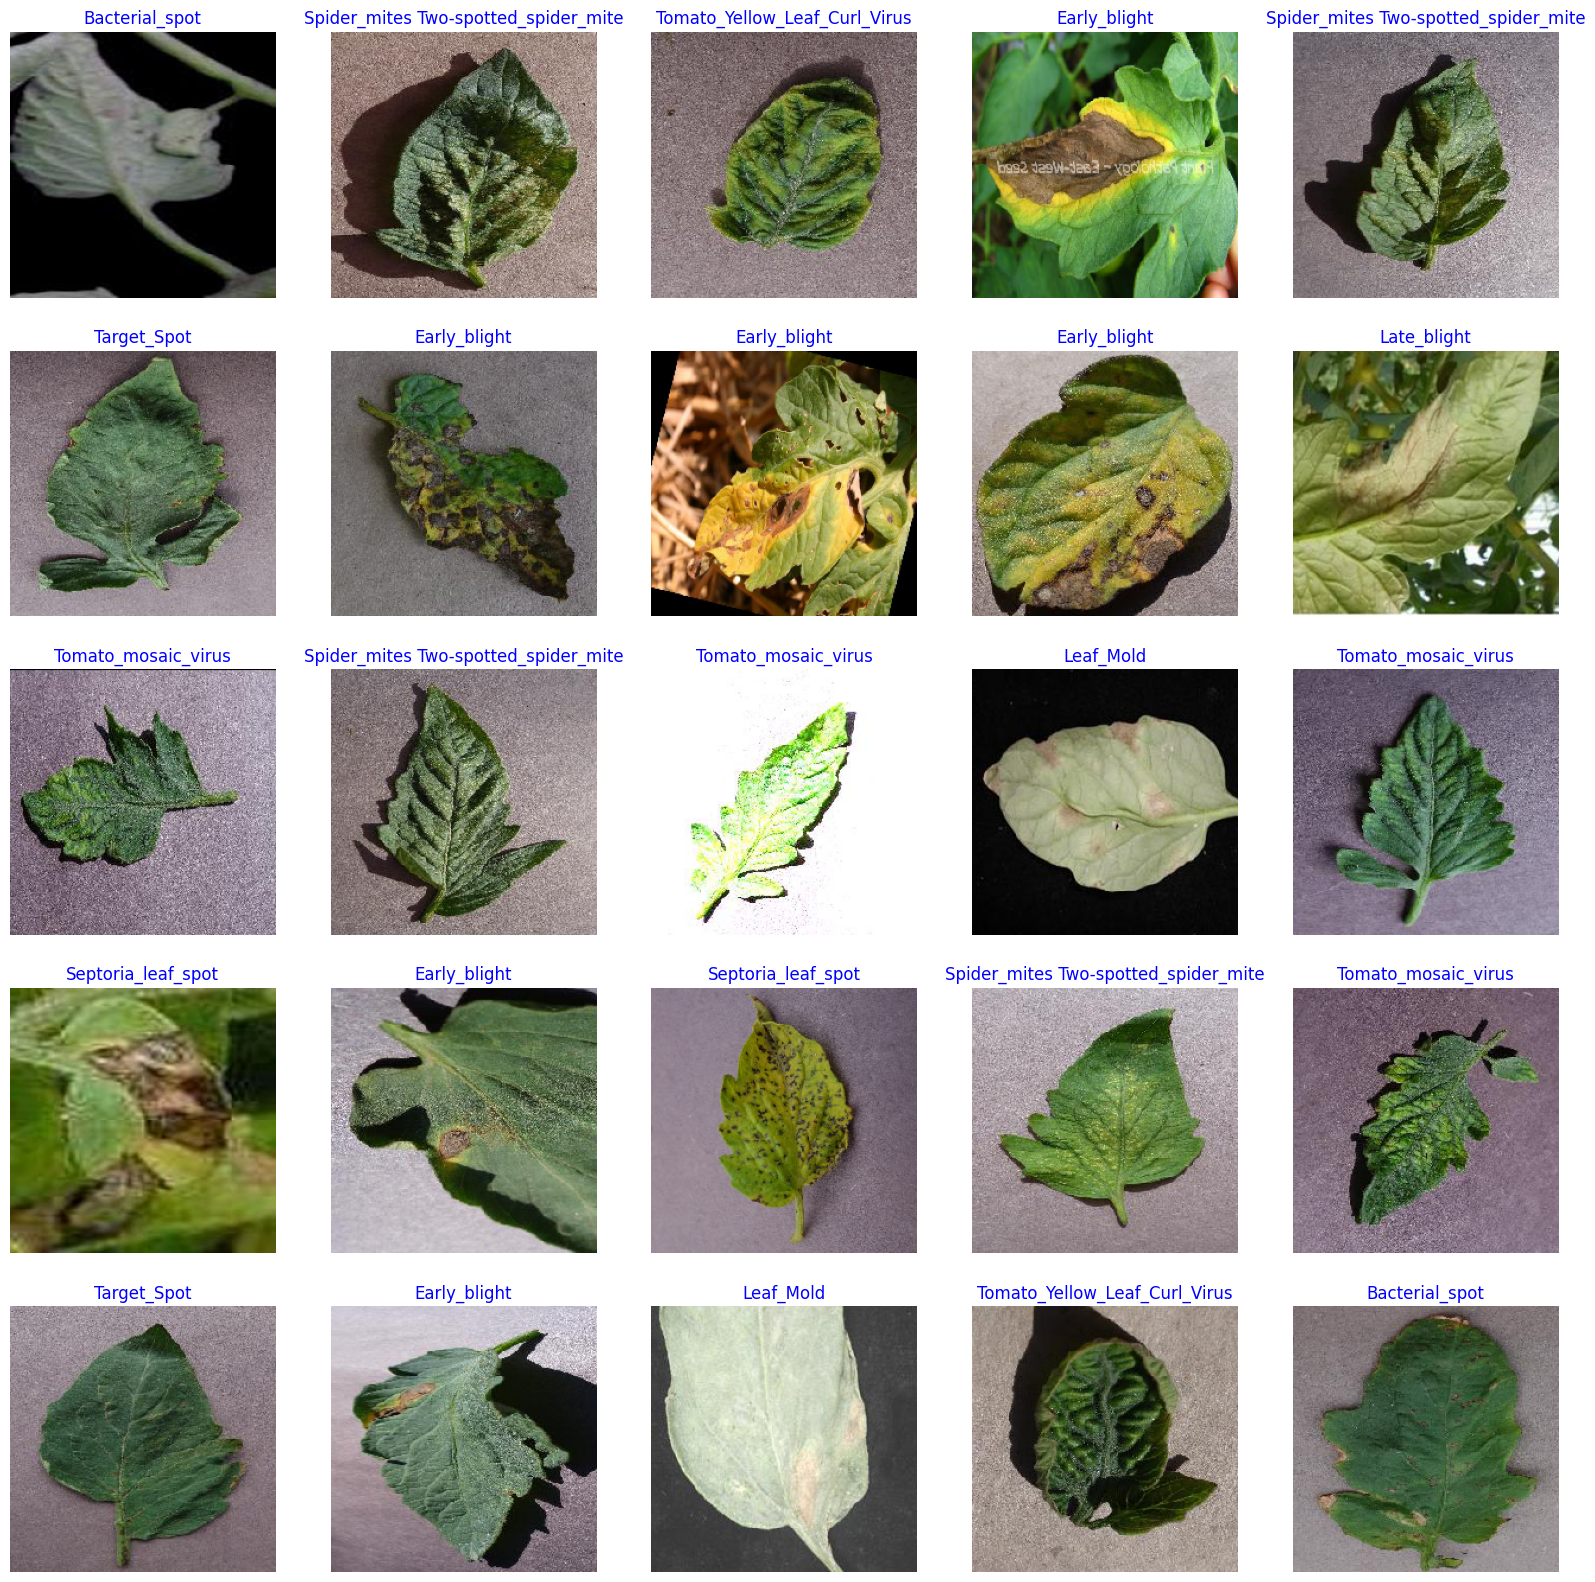

In [ ]:
# Get Dataframes
train_dir = '/content/train'
valid_dir = '/content/valid'
train_df, valid_df, test_df = create_df(train_dir, valid_dir)

# Get Generators
batch_size = 32
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

show_images(train_gen)

Create Pre-trained model

In [ ]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model
with tf.device(device_name):
  base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

  model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
  ])

  model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

  model.summary()

Get custom callbacks parameters

In [ ]:
batch_size = 32
epochs = 5
patience = 1
stop_patience = 3
threshold = 0.9
factor = 0.5
freeze = False
batches = int(np.ceil(len(train_gen.labels) / batch_size))

callbacks = [MyCallback(model= model, base_model= base_model, patience= patience,
            stop_patience= stop_patience, threshold= threshold, factor= factor,
            batches= batches, initial_epoch= 0, epochs= epochs)]

Train model

In [ ]:
history = model.fit(x= train_gen, epochs= epochs, verbose= 0, callbacks= callbacks,
                    validation_data= valid_gen, validation_steps= None, shuffle= True,
                    initial_epoch= 0)

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /5      4.212   84.705   1.39223  97.305   0.00100  0.00100  accuracy     0.00    556.98 
 2 /5      0.812   95.609   0.38255  98.885   0.00100  0.00100  val_loss    72.52    476.13 
 3 /5      0.395   97.192   0.26970  99.104   0.00100  0.00100  val_loss    29.50    476.61 
 4 /5      0.297   98.232   0.21643  99.555   0.00100  0.00100  val_loss    19.75    476.78 
 5 /5      0.254   98.611   0.17816  99.729   0.00100  0.00100  val_loss    17.68    476.34 
training elapsed time was 0.0 hours, 41.0 minutes, 3.81 seconds)


Plot training history

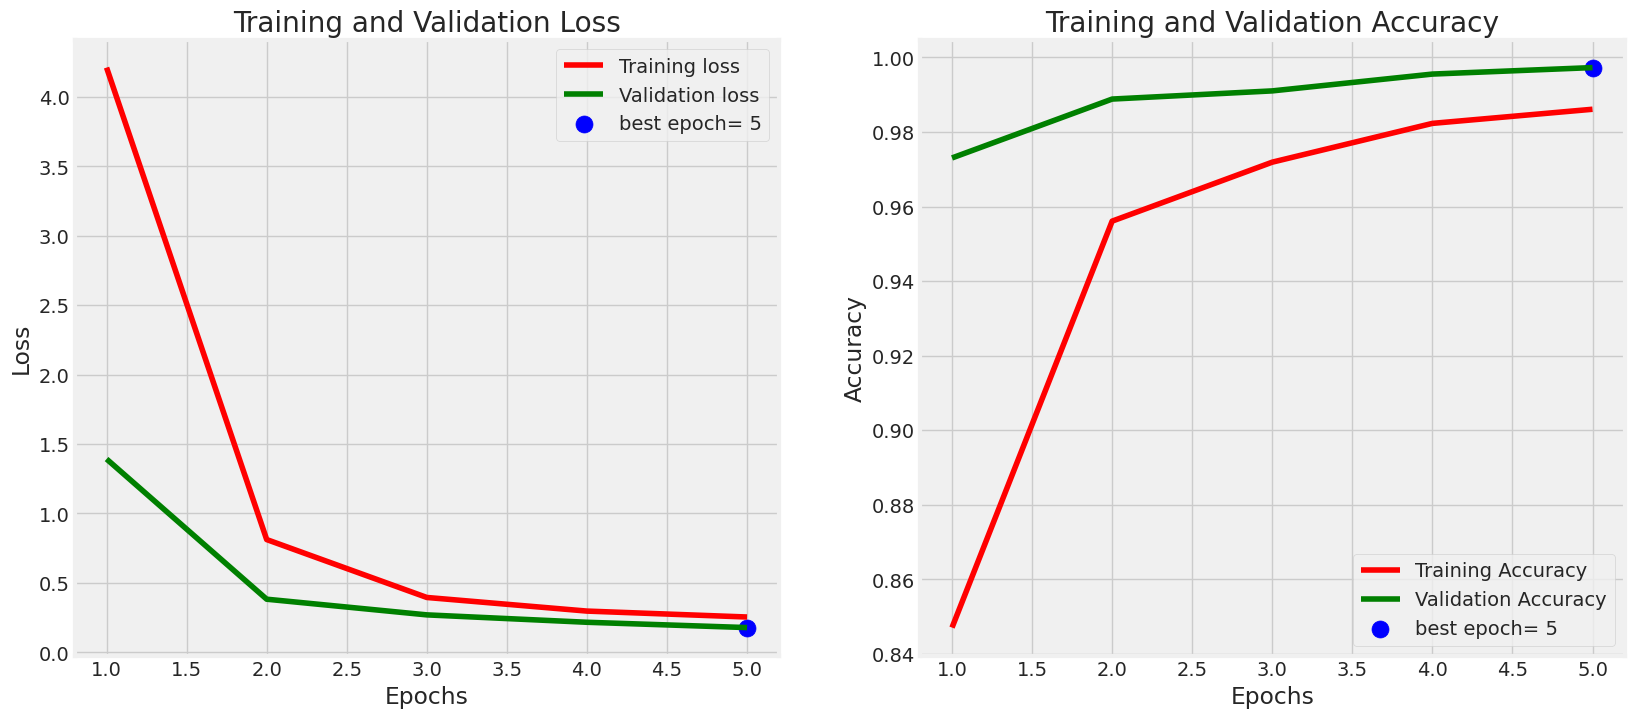

In [ ]:
plot_training(history)

Evaluate model

In [ ]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size
train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

383/383 [==============================] - 47s 121ms/step - loss: 0.1800 - accuracy: 0.9970
Train Loss:  0.17812779545783997
Train Accuracy:  0.9973074197769165
--------------------
Validation Loss:  0.17743279039859772
Validation Accuracy:  0.9974706172943115
--------------------
Test Loss:  0.17997638881206512
Test Accuracy:  0.9970022439956665


Make prediction

In [ ]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

<ipython-input-20-4f04c24daf97>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_gen)


[10  9  0 ...  8  3  2]


Confusion Matrix and Classification Report

Confusion Matrix, Without Normalization
[[1129    0    0    0    0    0    0    0    0    1    0]
 [   0  977    0    0    4    0    0    0    0    1    0]
 [   0    2 1242    0    0    0    0    0    0    1    0]
 [   0    0    0 1101    1    0    0    0    0    0    0]
 [   5    0    0    3 1143    0    0    0    0    2    0]
 [   0    0    0    0    0  698    1    0    0    0    0]
 [   0    0    0    0    0    0  729    0    0    2    0]
 [   0    0    0    0    0    0    0  816    0    0    0]
 [   1    0    0    0    0    0    1    0  858    1    0]
 [   0    0    0    0    0    0    0    0    0 1220    0]
 [   0    0    0    5    0    0    0    0    0    0  397]]
                               precision    recall  f1-score   support

               Bacterial_spot       0.99      1.00      1.00      1130
                 Early_blight       1.00      0.99      1.00       982
                  Late_blight       1.00      1.00      1.00      1245
                    Leaf_Mold       

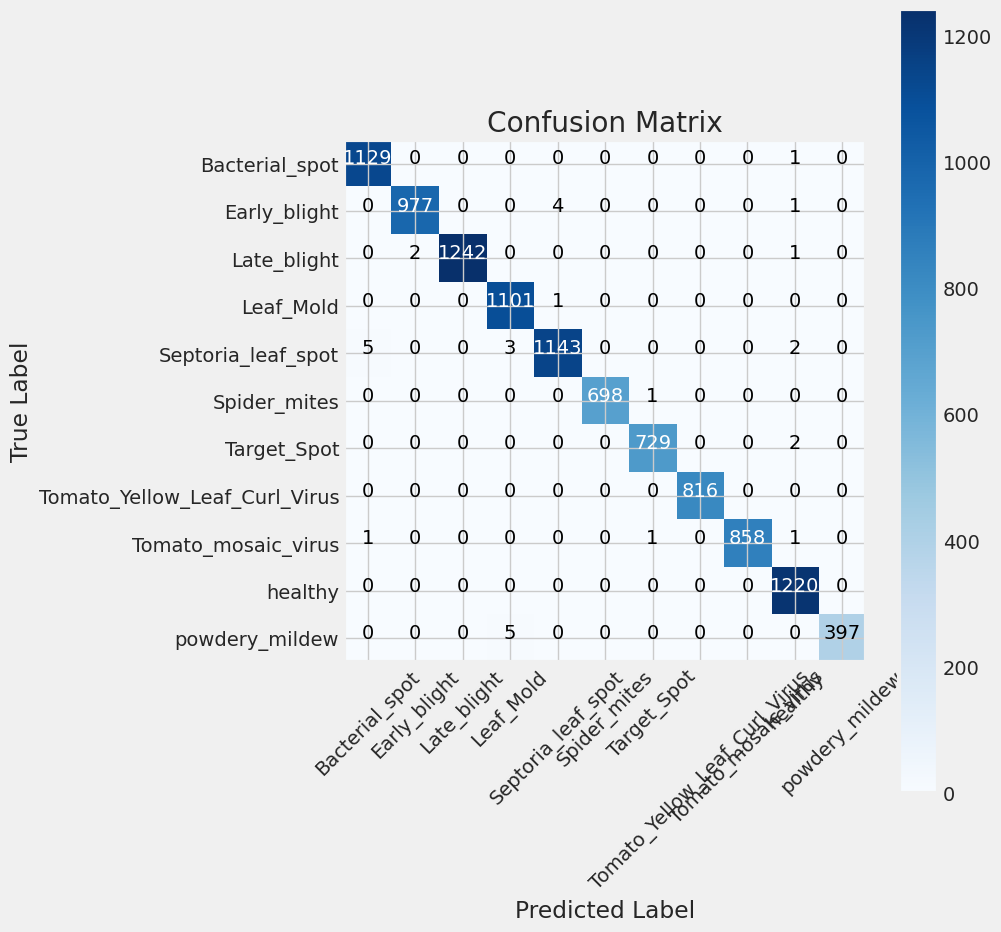

In [ ]:
target_names = ['Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 'Spider_mites', 'Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_mosaic_virus', 'healthy', 'powdery_mildew']
# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= target_names))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Save model

In [ ]:
model_name = 'EffecientNetB3'
subject = 'Tomato-Disease-Detection'
acc = test_score[1] * 100
save_path = ''

save_id = str(f'{model_name}-{subject}-{"%.2f" %round(acc, 2)}')
tf.saved_model.save(model,save_id)
model=tf.saved_model.load(save_id)
converter=tf.lite.TFLiteConverter.from_saved_model(save_id)
tflite_model=converter.convert()
print(f'model was saved as {save_id}')

In [ ]:
tfm_file='efficient_tflite.tflite'
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)
print(f'tf model was saved as {save_id}')

Save class indices in CSV

In [ ]:
class_dict = train_gen.class_indices
height = []
width = []
for _ in range(len(class_dict)):
    height.append(img_size[0])
    width.append(img_size[1])

Index_series = pd.Series(list(class_dict.values()), name= 'class_index')
Class_series = pd.Series(list(class_dict.keys()), name= 'class')
Height_series = pd.Series(height, name= 'height')
Width_series = pd.Series(width, name= 'width')
class_df = pd.concat([Index_series, Class_series, Height_series, Width_series], axis= 1)
subject = ''
csv_name = f'{subject}-class_dict.csv'
csv_save_loc = os.path.join(save_path, csv_name)
class_df.to_csv(csv_save_loc, index= False)
print(f'class csv file was saved as {csv_save_loc}')

In [ ]:
!zip -r /content/EffecientNetB3-Tomato-Disease-Detection2.zip /content/EffecientNetB3-Tomato-Disease-Detection-99.67

In [ ]:
from google.colab import files
shutil.copy("/content/EffecientNetB3-Tomato-Disease-Detection2.zip","/content/drive/MyDrive/datasets")
shutil.copy("/content/model.tflite","/content/drive/MyDrive/datasets")

